# DC 仓库的选址决策

In [1]:
import numpy as np 
import pandas as pd 

In [2]:
data = pd.read_csv('C:/ML/path-with-D5-D6.csv')

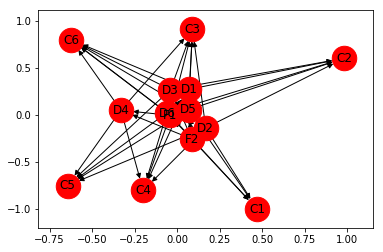

In [4]:
import networkx as nx
%matplotlib inline
FG = nx.DiGraph()
FG = nx.from_pandas_edgelist(data, source='origin', target='dest', edge_attr=True,create_using=nx.DiGraph())

FG.nodes()
FG.edges()
nx.draw_networkx(FG, with_labels=True,node_size=600, node_color='r') 

In [6]:
#若从F1工厂发出
path1={}
for i in range(1,7):
    path1['C'+str(i)]=nx.dijkstra_path(FG, source='F1', target="C"+str(i), weight='cost')
path1

{'C1': ['F1', 'C1'],
 'C2': ['F1', 'D6', 'C2'],
 'C3': ['F1', 'D4', 'C3'],
 'C4': ['F1', 'D6', 'C4'],
 'C5': ['F1', 'D4', 'C5'],
 'C6': ['F1', 'C6']}

In [7]:
#若从F2工厂发出
path2={}
for i in range(1,7):
    path2['C'+str(i)]=nx.dijkstra_path(FG, source='F2', target="C"+str(i), weight='cost')
path2

{'C1': ['F2', 'D2', 'C1'],
 'C2': ['F2', 'D6', 'C2'],
 'C3': ['F2', 'D4', 'C3'],
 'C4': ['F2', 'D6', 'C4'],
 'C5': ['F2', 'D4', 'C5'],
 'C6': ['F2', 'D6', 'C6']}

In [8]:
#从F1发出时，到达各客户最优费用
import collections
origin=data['origin']
dest=data['dest']
weight=data['cost']
fee=collections.defaultdict(dict)
best_fee1=collections.defaultdict(int)
for i in range(len(origin)):
    fee[origin[i]][dest[i]]=weight[i]
for i in range(1,7):
    sig=path1['C'+str(i)]
    length=len(sig)
    for j in range(length-1):
        best_fee1['C'+str(i)]+=fee[sig[j]][sig[j+1]]
best_fee1

defaultdict(int,
            {'C1': 1.0,
             'C2': 0.80000000000000004,
             'C3': 0.40000000000000002,
             'C4': 0.90000000000000002,
             'C5': 0.69999999999999996,
             'C6': 1.0})

In [9]:
#从F2发出时，到达各客户最优费用
best_fee2=collections.defaultdict(int)
for i in range(len(origin)):
    fee[origin[i]][dest[i]]=weight[i]
for i in range(1,7):
    sig=path2['C'+str(i)]
    length=len(sig)
    for j in range(length-1):
        best_fee2['C'+str(i)]+=fee[sig[j]][sig[j+1]]
best_fee2

defaultdict(int,
            {'C1': 1.3,
             'C2': 0.69999999999999996,
             'C3': 0.40000000000000002,
             'C4': 0.80000000000000004,
             'C5': 0.69999999999999996,
             'C6': 1.2})

In [10]:
fee_diff=collections.defaultdict(int)
for i in range(1,7):
    fee_diff['C'+str(i)]=best_fee1['C'+str(i)]-best_fee2['C'+str(i)]
fee_diff


defaultdict(int,
            {'C1': -0.30000000000000004,
             'C2': 0.10000000000000009,
             'C3': 0.0,
             'C4': 0.099999999999999978,
             'C5': 0.0,
             'C6': -0.19999999999999996})

在理想情况下，不考虑仓库吞吐量限制下，最优的发送方式为：
F1-C1 50000吨 价格50000x1
F2-D6-C2 10000吨 价格10000x0.7
F2-D4-C3 40000吨 价格40000x0.4
F2-D6-C4 35000吨 价格35000x0.8
F1-D4-C5 60000吨 价格60000x0.7
F1-C6 20000吨 价格20000x1
总物流费用： 163000元
实际总费用：物流费用+D6成本/12个月-关闭D1节省的成本/12个月=163000+4000/12-10000/12=162500元

考虑到仓库吞吐量，我们需要调整我们的方案，可以看到D4仓库吞吐量明显不足，并且由于要用到D6仓库，D6仓库的使用也会有费用产生，需要综合考虑上述因素：

1.考虑D4(20000)吞吐量不足：
C3(40000吨)的次优路线分别为：
F2-D5-C3 0.9x15000
F1-D1-C3 1.0x35000
F2-D2-C3 0.8x25000
C5(60000吨)次优路线分别为：
F2-D3-C5 1.0x50000
F2-D5-C5 0.7x15000

2.考虑D6(12500)吞吐量不足：
C2(10000吨)次优路线有：
F2-D2-C2 0.8x10000
F2-D5-C2 1x10000
C4(35000吨)次优路线有：
F2-D2-C4 1.3x25000

3.优先满足最优次优差值大的：
F2-D6-C4 价格12500x0.8  +F2-D2-C4 价格20000x1.3 + F1-D1-C4 价格2500x2  D6已满，D2还可中转5000吨

F2-D4-C3 价格20000x0.4  + F1-D1-C3 价格20000x1

F2-D5-C2 价格5000x1  + F2-D2-C2 价格5000x0.8 

F2-D3-C5 价格50000x1 +F2-D5-C5 价格10000x0.7 

3.综上，满足条件的最优方案为：F1-C1 50000吨；F2-D5-C2 5000吨，F2-D2-C2 5000吨；F2-D4-C3 20000吨，F1-D1-C3 20000;F2-D6-C4 12500吨，F2-D2-C4 20000吨，F1-D1-C4 2500吨;F2-D3-C5 50000吨，F2-D5-C5 10000吨;F1-C6 20000吨

总物流费用：205000元
再考虑仓库D5,D6的费用，
每月总的费用为：205000+12000/12+4000/12=206333元


与D5,D6不开时候最优的总的费用（248500元）相比，节省了42167元

# 我们需要建 D5,D6 吗？

由上述分析可以发现，建D5,D6有利于成本的降低，因此需要建D5,D6

# D2 需要扩充仓库面积吗？

由上述分析可以看到，在其他条件不变，要满足限制条件，运往一些经销商的商品只能采用次优方案，而其实D2扩建对于成本的降低是有利的，从这个方面看需要扩充D2。但是在实际中，我们可以考虑扩建D6，这样能满足最优方案，对于成本的下降更大，这样的方式更加有效。

# 我们需要关闭 D1 或者 D4 吗？

这个情况和上面的有点相似，我们不用关闭D1或者D4，这对于成本的降低是有利的。但是最佳的方案是，扩大D4并关闭D1，这样发送给C3,C5的可以采用最佳路径，并且不用再采用在D1中转的次优发送方式，对于成本的节省效果更好。

# 什么是最好的发运模式，来达到最小物流成本，这个最佳成本是多少？

在理想情况下，不考虑仓库吞吐量限制下，最优的发送方式为：
F1-C1 50000吨 价格50000x1
F2-D6-C2 10000吨 价格10000x0.7
F2-D4-C3 40000吨 价格40000x0.4
F2-D6-C4 35000吨 价格35000x0.8
F1-D4-C5 60000吨 价格60000x0.7
F1-C6 20000吨 价格20000x1
总物流费用： 163000元
实际最佳成本：物流费用+D6成本/12个月-关闭D1节省的成本/12个月=163000+4000/12-10000/12=162500元